In [1]:
from inspect import signature
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import tree
from sklearn.metrics import precision_recall_curve, average_precision_score

# Load Data

We want to perform two prediction tasks 
1. Siderophore vs not Siderophore
2. Binned Molecular Weight

These prediction tasks will be analyzed across two factors
1. Gram type (+/-)
2. Protein family type (pfam, cath, substrate binding protein, combinations)

To do this, we will create a single dataframe per task. This dataframe will contain the following information
- Protein family features
- BGC id
- Gram status
- label

We will then break this apart into features and predictions by group in order to perform predictions.

## Metadata

MIBiG metadata has some tricks and we perform this operation a lot, so I've put it in a function. This ensures that if it's edited, this automatically propagates into all analyses.

Cath and tcdb metadata are simpler.

In [2]:
from data_loading import load_mibig_metadata

mibig_metadata = load_mibig_metadata()
cath_metadata = pd.read_csv('./data/metadata/final_fun_families.tsv', sep='\t')
tcdb_metadata = pd.read_csv('./data/metadata/tcdb_families.tsv', sep='\t') # Currently unused in this notebook

## Loading MIBiG

Now we will load cath and pfam. Putting them in a dict will make it easier to generate lots of analyses in a single loop.

In [3]:
mibig_pfam = pd.read_csv(
    './data/pfam/mibig_pfam20.tsv', sep='\t').dropna(how='all', axis='columns')
mibig_pfam['ABC2_membrane_3'] = mibig_pfam['ABC2_membrane_3'] + \
    mibig_pfam['ABC2_membrane_3.1']
del mibig_pfam['ABC2_membrane_3.1']
mibig_pfam = mibig_pfam.drop(['Order'], axis=1)
               
mibig_cath = pd.read_csv(
    './data/cathdb/mibig_cathdb.tsv', sep='\t').dropna(how='all', axis='columns')
mibig_cath = mibig_cath[['BGC'] + list(cath_metadata['FunFam'])]

mibig_features = {
    'pfam': mibig_pfam,
    'cath': mibig_cath
}

Let's now add the Gram status column to our features, again with the goal of making analysis easier to automate. Note that some of the BGCs to not have Gram status.

In [4]:
for key, data in mibig_features.items():
    mibig_features[key] = data.join(mibig_metadata[['BGC', 'Gram']].set_index('BGC'), on='BGC')
    print(f'Number of examples of type {key} with no Gram status: {mibig_features[key].Gram.isna().sum()}')

Number of examples of type pfam with no Gram status: 22
Number of examples of type cath with no Gram status: 27


## Preparing Siderophore Data

Now let's create the features and labels for the siderophore prediction task.

To create the labels, we will take all BGCs which have Antifungal or Antibacterial as labels and call them negative. All things labelled as Siderophore will be positive.

In [5]:
siderophore_idx = (mibig_metadata.Antibacterial.isin([1]) | 
                   mibig_metadata.Antifungal.isin([1]) | 
                   mibig_metadata.Siderophore.isin([1]))

siderophore_meta = mibig_metadata[siderophore_idx]

(315, 17)

Note that there are three cases where something is both siderophore and antibacterial/antifungal. We should figure out how to handle these.

In [6]:
siderophore_meta[siderophore_meta[['Antibacterial', 'Antifungal', 'Siderophore']].sum(axis=1) > 1]

,BGC,Genus,Name,Compound_count,MW,TPSA,LOGP,HACC,HDON,Type,Activities,Structure,Gram,Antibacterial,Antifungal,Siderophore,Orf_length
225,BGC0000097,Streptomyces,ml-449,1,449.292994,69.56,5.57290,3.0,3.0,Polyketide,"Antibacterial,Antifungal",CCC/C=C/C=C/CC1C/C=C/C=C(/C=C/C=C/C(C(/C=C(/C=...,1,1,1,0,24
240,BGC0001435,Streptomyces,ikarugamycin,1,478.283158,95.50,4.01520,4.0,3.0,NRP,"Antibacterial,Antifungal",[H][C@]12C[C@@H](C)[C@@H](CC)[C@]1([H])C=C[C@]...,1,1,1,0,25
357,BGC0000024,Streptomyces,aureothin,1,397.152537,91.81,5.01234,6.0,0.0,Polyketide,"Antibacterial,Antifungal,Cytotoxic,insecticide",CC1=C(OC(=C(C1=O)C)OC)[C@H]2CC/C(=C/C(=C/C3=CC...,1,1,1,0,9
555,BGC0001130,Xenorhabdus,fabclavine ia,1,1355.951981,466.09,3.36620,17.0,16.0,NRP,"Antibacterial,Antifungal,Cytotoxic",CC(N)CCCCCCCC(N)CCCCCCCC(N)CCCCCCCC(N)CCCCCCC[...,0,1,1,0,14
669,BGC0000463,Pseudomonas,xantholysin a,3,1775.080823,663.59,-1.04270,22.0,20.0,NRP,"Antibacterial,Antifungal",CCCCCCCC(O)CC(NC(CC(C)C)C(NC(CCC(O)=O)C(NC(CCC...,0,1,1,0,4
834,BGC0000028,Streptomyces,bafilomycin b1,1,815.445591,207.38,5.04850,13.0,5.0,Polyketide,"Antibacterial,Antifungal,antineoplastic, immun...",COC1\C=C\C=C(C)\CC(C)C(O)C(C)\C=C(/C)\C=C(OC)\...,1,1,1,0,18
886,BGC0000224,Streptomyces,fredericamycin a,1,539.121631,171.06,3.40670,9.0,4.0,Polyketide,"Antibacterial,Antifungal,Cytotoxic,Inhibitor,a...",COC1=CC(=O)C2=C(C(O)=C3C(=O)[C@]4(CCC5=CC6=C(C...,1,1,1,0,33
987,BGC0000453,Streptomyces,valinomycin,1,1110.631160,332.40,2.34330,18.0,6.0,NRP,"Antibacterial,Antifungal,Cytotoxic,Antiviral",CC(C)[C@@H]1NC(=O)C(C)OC(=O)[C@H](NC(=O)[C@H](...,1,1,1,0,18
990,BGC0001120,Burkholderia,burkholderic acid,1,306.183109,63.60,4.52510,4.0,1.0,NRP,"Antibacterial,Cytotoxic,Siderophore,Virulence ...",CCCCCCC/C=C(\C)/C(=C1C=C(OC1=O)C(=O)CC)O,0,1,0,1,29
1273,BGC0001833,Burkholderia,icosalide a,2,712.462244,209.46,2.56060,10.0,6.0,NRP,"Antibacterial,Antifungal,Swarming/Biofilm Indu...",CCCCCCCC1CC(=O)NC(CO)C(=O)NC(CC(C)C)C(=O)OC(CC...,0,1,1,0,1


In [7]:
siderophore_data = {}
for key, data in mibig_features.items():
    # Subset to valid examples and append the label
    tmp = data[data.BGC.isin(siderophore_meta.BGC)]
    # WARNING!!! This assumes we want Siderophore to take precedence for the three examples above.
    tmp = tmp.join(siderophore_meta[['BGC', 'Siderophore']].set_index('BGC'), on='BGC')
    tmp = tmp.rename(columns={'Siderophore': 'label'})
    siderophore_data[key] = tmp

## Preparing Molecular Weight Data

For molecular weight, we take all examples which have valid structures. Each of these has a molecular weight assigned, which we will bin using the list `bins`. Note that this list can be modified freely.

We follow a similar process as above to generate the dataset.

In [8]:
valid_struct_idx = ~mibig_metadata.Structure.isnull()
struct_meta = mibig_metadata[valid_struct_idx]

In [9]:
# Bin molecular weight and append to metadata
bins = [500, 1500]
bins = [0] + bins + [10000]
x = struct_meta.MW.copy()
struct_meta = struct_meta.assign(label = pd.cut(x.copy(), bins, labels=False))

mw_data = {}
for key, data in mibig_features.items():
    # Subset to valid examples and append the label
    tmp = data[data.BGC.isin(struct_meta.BGC)]
    mw_data[key] = tmp.join(struct_meta[['BGC', 'label']].set_index('BGC'), on='BGC')

## Prediction Analysis without Data Splits

Let's do some simple prediction without any cross-validation. This well let us see what we learn from the full data and confirm our datasets look reasonable.

Here's a simple function for fitting decision trees and showing the results. It plots
1. The tree with the quality of each split 
2. A precision recall curve for the classifier.

In [10]:
def fit_tree_and_plot_results(X: pd.DataFrame,
                              y: pd.Series,
                              max_depth: int=2,
                              min_samples_split: int=3) -> tree.DecisionTreeClassifier:
    clf = tree.DecisionTreeClassifier(max_depth=max_depth,
                                  min_samples_split=min_samples_split)
    clf = clf.fit(X, y)
    preds = clf.predict_proba(X)
    
    # Plot PR Curve
    average_precision = average_precision_score(y, preds[:, 1])
    precision, recall, _ = precision_recall_curve(y, preds[:, 1])

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))
    
    # Plot the actual tree
    plt.figure(figsize=(10, 10))
    tree.plot_tree(clf, feature_names=X.columns)
    plt.show()
    return clf, preds

In both cases, we will be performing a binary task by looping over protein families and gram types. Let's put that into one function for ease of use.

In [11]:
def grouped_fit_and_plot(dataset):
    models = {'pfam': {}, 'cath': {}}
    for protein_fam, data in dataset.items():
        for group, dataset in data.groupby(['Gram']):
            if group > 1:
                print('Not sure what Gram > 1 means, skipping.')
                continue
            print(f'Protein set: {protein_fam}, Gram: {group}')
            X = dataset.drop(['BGC', 'label', 'Gram'], axis=1)#.to_numpy()
            y = dataset['label'].to_numpy()
            clf, preds = fit_tree_and_plot_results(X, y)
            models[protein_fam][group] = clf
            print('='*100)
        
    return models

## Siderophore Prediction

First up is Siderophore prediction. We will fit four models: Gram + and Gram - x Pfam and Cath. For each we will fit a decision tree and visualize the tree as well as the performance. 

Notice that all of our trained models are stored nicely in the `siderophore_models` dict!

## (Reading the Tree)

It's surprisingly hard to find a simple tutorial on the decision tree visualization. Basically each node tells you a few things:
1. The rule used to make the split.
2. The gini coefficient of the node (a measure of purity)
3. The number of samples that arrived at that node
4. The number of examples per class, shown in "value = [x, y]". This means there are x examples from class 0 and y examples from class 1 that follow this decision path.

Also the arrow to the left means false and the arrow to the right means true.

Protein set: pfam, Gram: 0.0


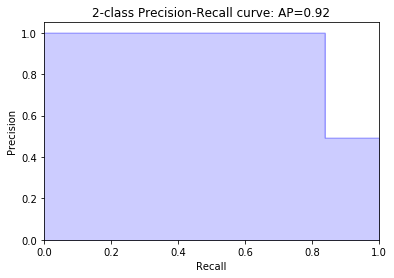

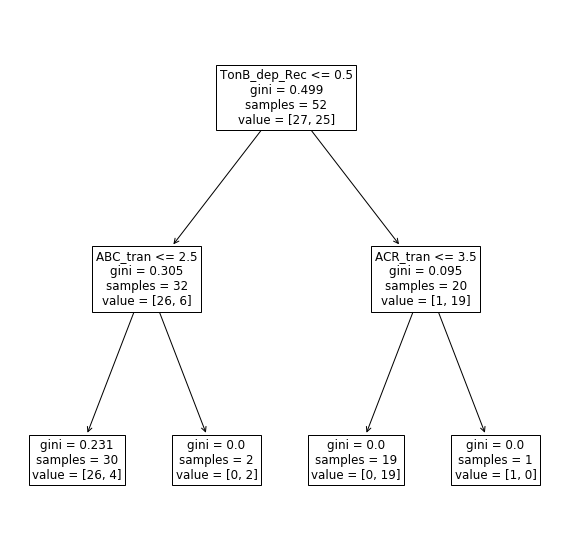

Protein set: pfam, Gram: 1.0


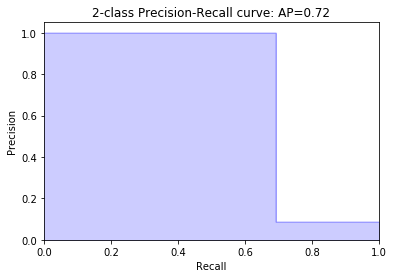

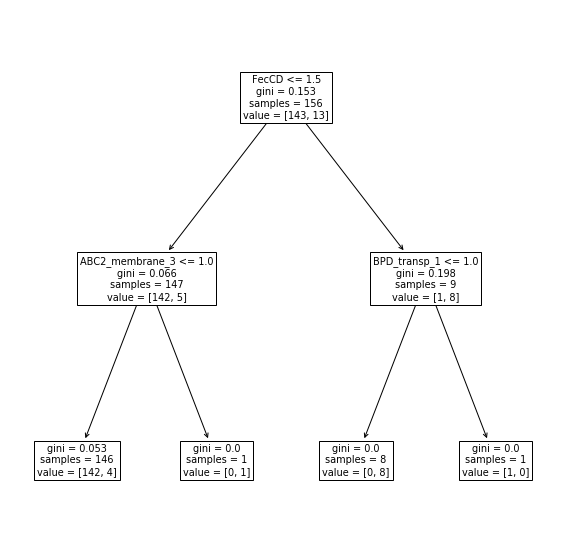

Not sure what Gram > 1 means, skipping.
Not sure what Gram > 1 means, skipping.
Protein set: cath, Gram: 0.0


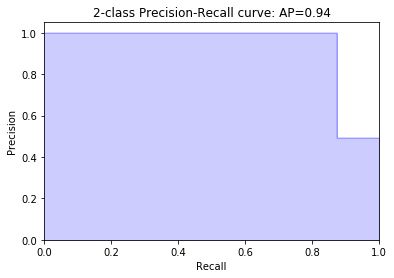

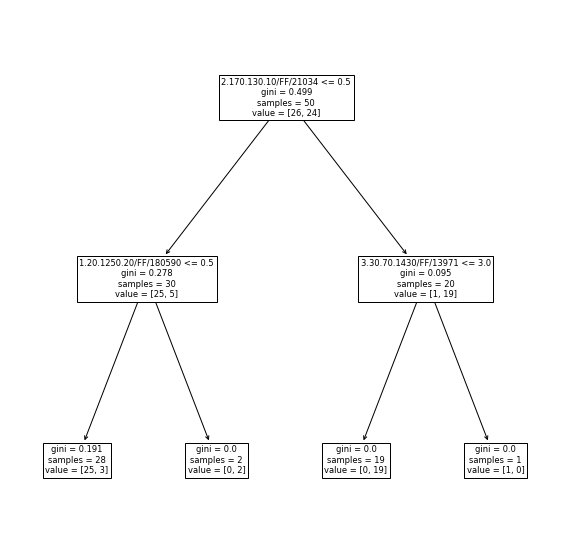

Protein set: cath, Gram: 1.0


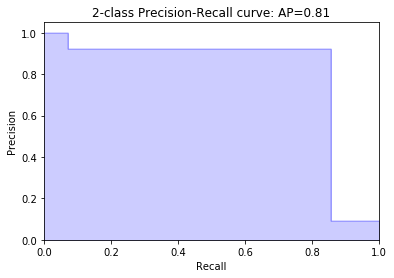

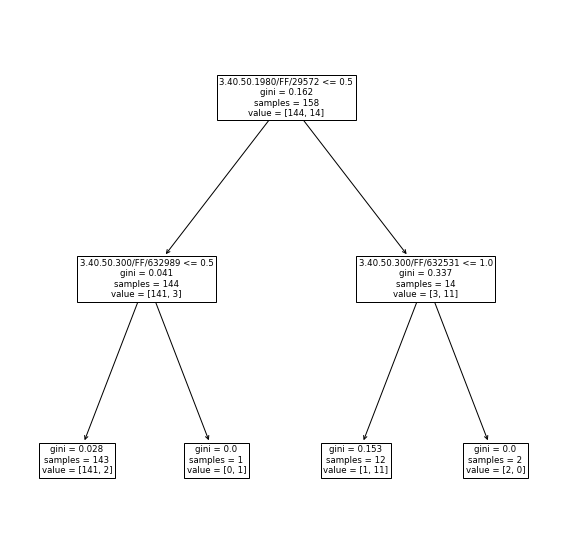

Not sure what Gram > 1 means, skipping.
Not sure what Gram > 1 means, skipping.


In [12]:
siderophore_models = grouped_fit_and_plot(siderophore_data)

## Heavy vs Light Prediction

Let's perform an identical analysis for molecular weight. In this case, I will ignore the 500-1500 range so the task is binary. 

In [13]:
binarized_mw = mw_data.copy()
for key, data in binarized_mw.items():
    # Filter out original 1s then turn original 2s into 1s
    binarized = data[data.label != 1]
    binarized.label = binarized.label.replace(2, 1)
    binarized_mw[key] = binarized

/home/nickbhat/projects/bgc_tran/venv/lib/python3.6/site-packages/pandas/core/generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Protein set: pfam, Gram: 0.0


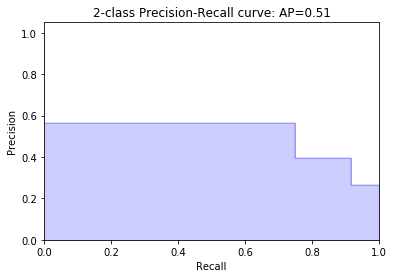

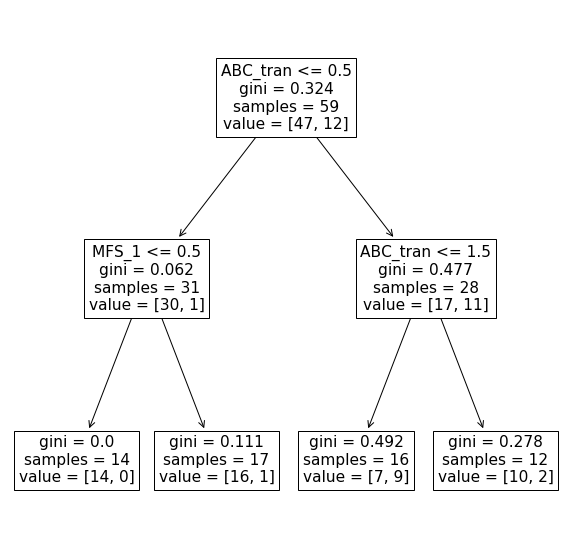

Protein set: pfam, Gram: 1.0


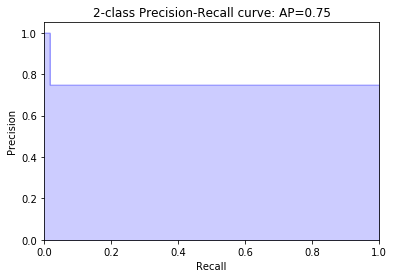

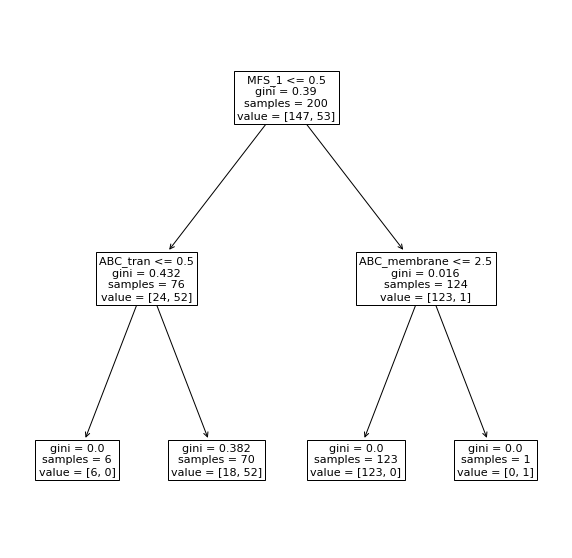

Not sure what Gram > 1 means, skipping.
Not sure what Gram > 1 means, skipping.
Protein set: cath, Gram: 0.0


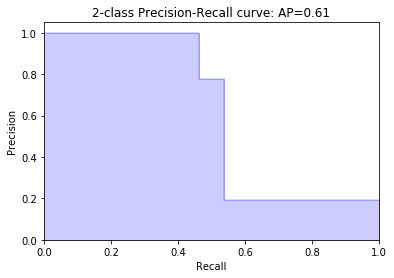

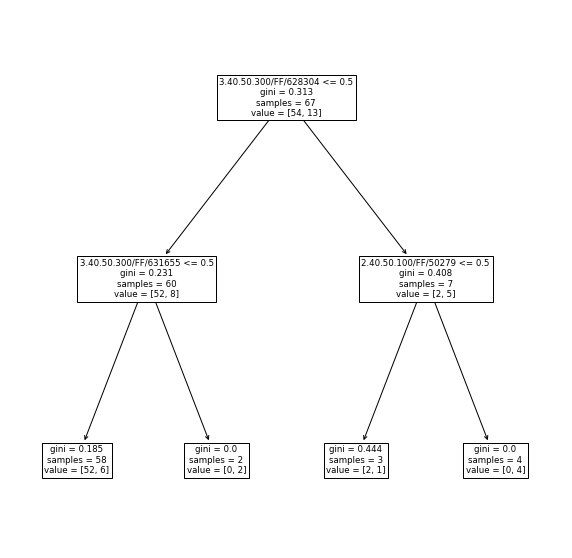

Protein set: cath, Gram: 1.0


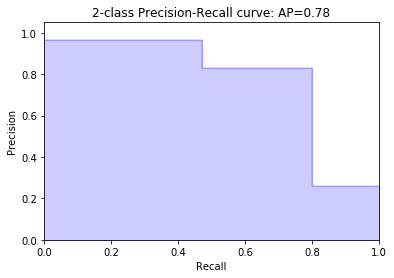

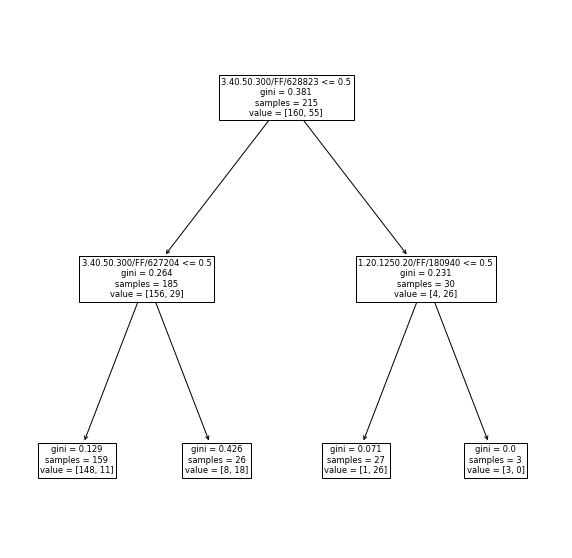

Not sure what Gram > 1 means, skipping.
Not sure what Gram > 1 means, skipping.


In [14]:
mw_models = grouped_fit_and_plot(binarized_mw)